#Ανίχνευση εγκεφαλικών όγκων από μαγνητικές τομογραφίες ασθενών με πολύμορφο γλοιοβλάστωμα

In [ ]:
pip install pydicom

In [ ]:
pip install pillow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

##Load Data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pydicom import dcmread
from pydicom.pixel_data_handlers.util import apply_voi_lut,  apply_modality_lut
from skimage.morphology import watershed
from skimage import exposure
import cv2


def load_data(dicom_path, image_path, gray_image_path):
    
    ds = dcmread(dicom_path)

    modality = apply_modality_lut(ds.pixel_array, ds)
    windowed = apply_voi_lut(ds.pixel_array, ds)

    cv2.imwrite(image_path,ds.pixel_array)
    plt.imshow(ds.pixel_array, cmap='bone')
    plt.axis('off')
    plt.savefig(gray_image_path)
    plt.show()



#Skull Removal

In [ ]:
def skull_removal(img):

    orig_img = cv2.imread(img,1)
    gray_img = cv2.cvtColor( orig_img, cv2.COLOR_BGR2GRAY )
    ret, markers = cv2.connectedComponents(gray_img)
    marker_area = [np.sum(markers==m) for m in range(np.max(markers)) if m!=0] 
    largest_component = np.argmax(marker_area)+1                     
    brain_mask = markers==largest_component
    brain_out = orig_img.copy()
    brain_out[brain_mask==False] = (0,0,0)
    brain = orig_img - brain_out
    plt.imshow(brain, cmap='bone')
    plt.title("After Skull Removal")
    plt.axis('off')
    plt.show()
    
    return brain

##High Pass Filter (Edge Detection) using Sobel Derivatives

In [ ]:
def hpf(img, gray_img):
    Gx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Gy = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    img_sobelx = cv2.Sobel(img, cv2.CV_8U, 1, 0, ksize=3)
    img_sobely = cv2.Sobel(img, cv2.CV_8U, 0, 1, ksize=3)
    img_sobel  = img_sobelx + img_sobely + gray_img
    plt.imshow(img_sobel, cmap='bone')
    plt.title("After High Pass Filter")
    plt.axis('off')
    plt.show()
    return img_sobel

##Median Filter (Noise Removal)

In [ ]:
def median_filter(img):
    median_filtered = cv2.medianBlur(img, 5)
    plt.imshow(median_filtered, cmap='bone')
    plt.title("After Median Filter")
    plt.axis('off')
    plt.show()
    return median_filtered 

##Threshold Segmentation

In [ ]:
def threshold_segmentation(img):
    thresh = cv2.threshold(img,0,255,cv2.THRESH_OTSU)[1]
    plt.imshow(thresh, cmap='bone')
    plt.title("After Threshold Segmentation")
    plt.axis('off')
    plt.show()
    return thresh

##Watershed Segmentation

In [ ]:
def watershed_segmentation(orig_img, gray_img, thr_img, path):
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thr_img,cv2.MORPH_OPEN,kernel, iterations = 2)
    sure_bg = cv2.dilate(opening,kernel,iterations=3)
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)
    contours, hierarchy = cv2.findContours(sure_fg,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    marker = np.zeros((gray_img.shape[0], gray_img.shape[1]),dtype = np.int32)
    marker = np.int32(sure_fg) + np.int32(sure_bg)
    for id in range(len(contours)):
        cv2.drawContours(marker,contours,id,id+2, -1)
    marker = marker + 1
    marker[unknown==255] = 0
    copy_img = orig_img.copy()
    test = cv2.watershed(copy_img, marker)
    plt.imshow(marker, cmap='bone')
    plt.axis('off')
    plt.savefig(path)
    plt.title("After Watershed Segmentation")
    plt.show()
    return marker

## Tumor Detection

In [ ]:
def tumor_detection(img, g_img, w_img, remove_skull = 1):

    orig_img = cv2.imread(img,1)
    gray_img = cv2.cvtColor( orig_img, cv2.COLOR_BGR2GRAY )
    if remove_skull:
        brain = skull_removal(img)
        brain = cv2.cvtColor( brain, cv2.COLOR_BGR2GRAY ) 
        h = hpf(brain, brain)
    else:
        h = hpf(gray_img, gray_img)
    m = median_filter(h )
    t = threshold_segmentation(m)
    w = watershed_segmentation(orig_img, gray_img, t, w_img)
    img1 = cv2.imread(g_img)
    img2 = cv2.imread(w_img)
    dst = cv2.addWeighted(img1, 0.5, img2, 0.7, 0)
    plt.imshow(dst, cmap = 'bone')
    plt.axis('off')
    plt.title("Tumor Detection")
    plt.show()
    

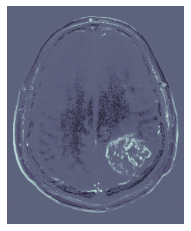

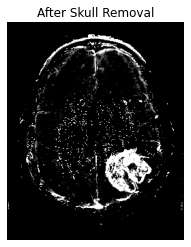

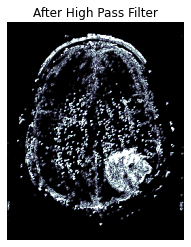

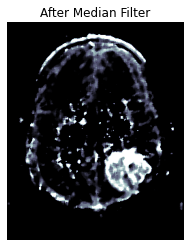

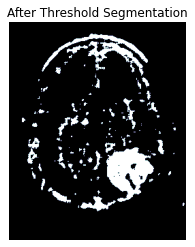

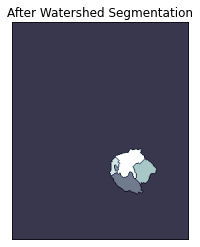

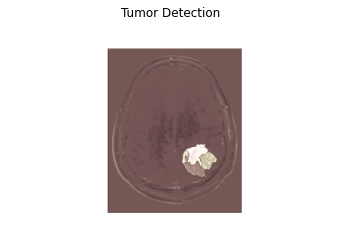

In [ ]:
mri =  '/content/drive/MyDrive/MRIs/29904.000000-dT1-04743/1-18.dcm'

image_path = 'mri.png'
gray_image_path = 'gray.png'
result_image = 'result.png'

load_data(img1, image_path, gray_image_path)
tumor_detection(image_path, gray_image_path, result_image,1)
